# Polymarket Continuous Quoter

An equation-based market making model for binary outcomes, inspired by **Avellaneda-Stoikov (2008)**.

## Key Design Principles

1. **Spreads** are a function of BOTH inventory imbalance AND cost basis (with interaction)
2. **Sizes** are a function of inventory imbalance only
3. **Multiplicative model** to avoid overly sensitive behavior

---
## 1. Core Equations

### State Variables

**Inventory Imbalance** (normalized):
$$q = \frac{Q_{up} - Q_{down}}{Q_{up} + Q_{down}} \in [-1, 1]$$

**Cost Excess** (how much underwater):
$$\varepsilon = \max(0, c_{up} + c_{down} - 1)$$

### Spread Equations (Multiplicative Model)

**Base spread** (widens when underwater):
$$\delta_{base}^* = \delta_{base} \cdot (1 + \gamma_{cost} \cdot \varepsilon)$$

**Skew factor** (depends on imbalance, amplified when underwater):
$$\text{skew} = \gamma_{inv} \cdot q \cdot (1 + \gamma_{int} \cdot \varepsilon)$$

**Final spreads** (multiplicative application of skew):
$$\delta_{up} = \delta_{base}^* \cdot (1 + \text{skew})$$
$$\delta_{down} = \delta_{base}^* \cdot (1 - \text{skew})$$

### Size Equations
$$S_{up} = S_{base} \cdot e^{-\lambda \cdot q}$$
$$S_{down} = S_{base} \cdot e^{+\lambda \cdot q}$$

### Bid Prices
$$bid_{up} = fair_{up} - \delta_{up}$$
$$bid_{down} = fair_{down} - \delta_{down}$$

### Why This Model Works

| Imbalance | Cost | Effect |
|-----------|------|--------|
| Good (q≈0) | Good (ε=0) | Base spread only, no skew → tight both sides |
| Bad (q≠0) | Good (ε=0) | Base spread + skew → favor underweight side |
| Good (q≈0) | Bad (ε>0) | Widened base, no skew → wide both sides equally |
| Bad (q≠0) | Bad (ε>0) | Widened base + **amplified** skew → aggressive rebalance |

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Tuple

plt.style.use('dark_background')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3

---
## 2. Model Implementation

In [2]:
@dataclass
class Position:
    """Represents a position in one outcome"""
    outcome: str
    qty: float
    avg_cost: float  # Decimal (0.471 = 47.1 cents)


@dataclass
class QuoteResult:
    """Output from the quoter"""
    bid_up: float
    spread_up: float
    size_up: float
    bid_down: float
    spread_down: float
    size_down: float
    q_imbalance: float
    cost_excess: float
    combined_cost: float
    base_spread: float  # For diagnostics
    skew: float         # For diagnostics
    
    def summary(self):
        print("=" * 65)
        print("QUOTE OUTPUT")
        print("=" * 65)
        print(f"Up:   bid = {self.bid_up*100:5.1f}c   spread = {self.spread_up*100:4.2f}c   size = {self.size_up:5.0f}")
        print(f"Down: bid = {self.bid_down*100:5.1f}c   spread = {self.spread_down*100:4.2f}c   size = {self.size_down:5.0f}")
        print("-" * 65)
        print(f"State: q = {self.q_imbalance:+.3f} | cost = {self.combined_cost*100:.1f}c | excess = {self.cost_excess*100:.1f}c")
        print(f"Model: base_spread = {self.base_spread*100:.2f}c | skew = {self.skew:+.3f}")
        print("-" * 65)
        print(f"Combined bid: {(self.bid_up + self.bid_down)*100:.1f}c  (fills improve avg if < 100c)")
        print("=" * 65)

In [ ]:
# =============================================================================
# POLYMARKET TICK SIZE CONSTRAINT
# =============================================================================
# All prices must be multiples of TICK_SIZE (0.01 = 1 cent)
# Valid prices: 0.01, 0.02, 0.03, ... 0.98, 0.99
# Sub-tick values like 0.005 or 0.0123 are IMPOSSIBLE on Polymarket
# =============================================================================

TICK_SIZE = 0.01  # Polymarket minimum price increment (1 cent)


def snap_to_tick(value: float, tick_size: float = TICK_SIZE) -> float:
    """
    Snap a price or spread to the nearest valid tick.
    
    Example: snap_to_tick(0.0123) -> 0.01
             snap_to_tick(0.0167) -> 0.02
    """
    return round(round(value / tick_size) * tick_size, 2)


class ContinuousQuoter:
    """
    Avellaneda-Stoikov inspired quoter with proper cost-imbalance interaction.
    
    SPREAD is a function of BOTH imbalance and cost (multiplicative model).
    SIZE is a function of imbalance only.
    
    All outputs are snapped to TICK_SIZE (0.01 = 1 cent) grid.
    
    Parameters
    ----------
    delta_base : float (default: 0.01 = 1 tick, range: 0.01 - 0.05 = 1-5 ticks)
        MINIMUM EDGE PER TRADE. Your spread when everything is perfect 
        (balanced inventory, in profit). 
        - 1 tick (0.01) = aggressive, more fills but thin margin
        - 5 ticks (0.05) = conservative, fewer fills but better margin
        MUST be >= TICK_SIZE. Sub-tick values are impossible.
    
    gamma_cost : float (default: 3.0, range: 2.0 - 5.0)
        COST RECOVERY URGENCY. Multiplier on base spread when underwater.
        Formula: base_spread *= (1 + gamma_cost * cost_excess)
        - At 20% underwater with gamma_cost=3: base widens by 60%
        - Higher = more defensive when losing, slower but safer recovery
        - Lower = aggressive, faster recovery but riskier
    
    gamma_inv : float (default: 0.5, range: 0.3 - 0.7)
        REBALANCING STRENGTH. Controls skew magnitude based on imbalance.
        - At 50% imbalance with gamma_inv=0.5: skew = 0.25
        - Higher = aggressive rebalancing, quickly corrects imbalance
        - Lower = tolerates imbalance longer, more patient
    
    gamma_int : float (default: 2.0, range: 1.0 - 3.0)
        PANIC MULTIPLIER. Amplifies skew when BOTH underwater AND imbalanced.
        This is the "bad situation" accelerator.
        Formula: skew *= (1 + gamma_int * cost_excess)
        - At 20% underwater: skew is multiplied by 1.4
        - Higher = aggressive exit from dangerous positions
        - Lower = steady behavior regardless of cost situation
    
    lambda_size : float (default: 1.0, range: 0.5 - 2.0)
        SIZE DECAY RATE. Exponential penalty on order size based on imbalance.
        Formula: size = base_size * exp(-lambda * q) for overweight side
        - At q=0.5 with lambda=1: overweight side gets 60%, underweight gets 165%
        - Higher = more aggressive size skew
        - Lower = more uniform sizes across both sides
    
    min_spread : float (default: 0.01 = 1 tick = 1 cent)
        FLOOR TO PREVENT GIVING AWAY EDGE. Even in perfect conditions, 
        never quote tighter than this. 
        MUST be >= TICK_SIZE (0.01). You cannot have sub-tick spreads.
        Protects against:
        1. Adverse selection from informed traders
        2. Exchange fees eating your edge  
        3. Latency disadvantage vs HFT
    
    max_spread : float (default: 0.10 = 10 ticks = 10 cents)
        CEILING TO STAY COMPETITIVE. Prevents spreads from widening so much 
        you never get filled. In extreme underwater + imbalanced scenarios, 
        the multiplicative model can produce very wide spreads. This cap:
        1. Ensures you remain in the market and can recover
        2. Prevents bid prices from going negative (bid = fair - spread)
    """
    
    def __init__(
        self,
        delta_base: float = 0.01,     # 1 tick base spread (range: 0.01-0.05)
        gamma_cost: float = 3.0,      # Cost sensitivity (range: 2.0-5.0)
        gamma_inv: float = 0.5,       # Inventory sensitivity for skew (range: 0.3-0.7)
        gamma_int: float = 2.0,       # Interaction amplifier (range: 1.0-3.0)
        lambda_size: float = 1.0,     # Size decay rate (range: 0.5-2.0)
        min_spread: float = 0.01,     # 1 tick floor (MINIMUM POSSIBLE)
        max_spread: float = 0.10,     # 10 tick ceiling
    ):
        self.delta_base = max(delta_base, TICK_SIZE)  # Enforce >= 1 tick
        self.gamma_cost = gamma_cost
        self.gamma_inv = gamma_inv
        self.gamma_int = gamma_int
        self.lambda_size = lambda_size
        self.min_spread = max(min_spread, TICK_SIZE)  # Enforce >= 1 tick
        self.max_spread = max_spread
    
    def compute_imbalance(self, q_up: float, q_down: float) -> float:
        """Normalized inventory imbalance in [-1, 1]"""
        total = q_up + q_down
        if total == 0:
            return 0.0
        return (q_up - q_down) / total
    
    def compute_cost_excess(self, c_up: float, c_down: float) -> Tuple[float, float]:
        """Returns (cost_excess, combined_cost)"""
        combined = c_up + c_down
        excess = max(0.0, combined - 1.0)
        return excess, combined
    
    def compute_spreads(self, q: float, cost_excess: float) -> Tuple[float, float, float, float]:
        """
        Compute spreads using multiplicative model with cost-imbalance interaction.
        All spreads are SNAPPED TO TICK GRID.
        
        Returns: (spread_up, spread_down, base_spread, skew)
        """
        # 1. Base spread: widens when underwater (multiplicative)
        cost_multiplier = 1.0 + self.gamma_cost * cost_excess
        base_spread_raw = self.delta_base * cost_multiplier
        
        # 2. Skew: depends on imbalance, AMPLIFIED when underwater
        interaction_multiplier = 1.0 + self.gamma_int * cost_excess
        skew = self.gamma_inv * q * interaction_multiplier
        
        # 3. Apply skew multiplicatively to base
        # When q > 0 (overweight up): spread_up increases, spread_down decreases
        spread_up_raw = base_spread_raw * (1.0 + skew)
        spread_down_raw = base_spread_raw * (1.0 - skew)
        
        # 4. Clamp to bounds
        spread_up_raw = max(self.min_spread, min(self.max_spread, spread_up_raw))
        spread_down_raw = max(self.min_spread, min(self.max_spread, spread_down_raw))
        
        # 5. SNAP TO TICK GRID (spreads must be whole cents)
        spread_up = snap_to_tick(spread_up_raw)
        spread_down = snap_to_tick(spread_down_raw)
        base_spread = snap_to_tick(base_spread_raw)
        
        return spread_up, spread_down, base_spread, skew
    
    def compute_sizes(self, q: float, base_size: float) -> Tuple[float, float]:
        """Exponential inventory penalty on sizes (function of imbalance only)"""
        size_up = base_size * math.exp(-self.lambda_size * q)
        size_down = base_size * math.exp(self.lambda_size * q)
        return size_up, size_down
    
    def quote(
        self,
        up_pos: Position,
        down_pos: Position,
        fair_up: float,
        fair_down: float,
        base_size: float = 100.0,
    ) -> QuoteResult:
        """Generate quotes for both outcomes. All prices SNAPPED TO TICK GRID."""
        # State
        q = self.compute_imbalance(up_pos.qty, down_pos.qty)
        cost_excess, combined_cost = self.compute_cost_excess(
            up_pos.avg_cost, down_pos.avg_cost
        )
        
        # Spreads (function of imbalance AND cost) - already tick-snapped
        spread_up, spread_down, base_spread, skew = self.compute_spreads(q, cost_excess)
        
        # Sizes (function of imbalance only)
        size_up, size_down = self.compute_sizes(q, base_size)
        
        # Bid prices - SNAP TO TICK GRID
        bid_up = snap_to_tick(max(TICK_SIZE, fair_up - spread_up))
        bid_down = snap_to_tick(max(TICK_SIZE, fair_down - spread_down))
        
        return QuoteResult(
            bid_up=bid_up,          # Already 2 decimal places
            spread_up=spread_up,    # Already 2 decimal places
            size_up=round(size_up, 1),
            bid_down=bid_down,      # Already 2 decimal places
            spread_down=spread_down,# Already 2 decimal places
            size_down=round(size_down, 1),
            q_imbalance=q,
            cost_excess=cost_excess,
            combined_cost=combined_cost,
            base_spread=base_spread,
            skew=skew,
        )

### Polymarket Tick Size Constraint

**TICK_SIZE = 0.01** (1 cent). All prices and spreads must be multiples of 0.01.

Valid prices: `0.01, 0.02, 0.03, ... 0.98, 0.99`

**IMPOSSIBLE values**: `0.005`, `0.0123`, `0.478` (sub-tick precision)

---

### Parameter Quick Reference

| Parameter | Default | Range | Purpose |
|-----------|---------|-------|---------|
| `delta_base` | 0.01 (1 tick) | **0.01 - 0.05** (1-5 ticks) | **Minimum edge** - spread in ideal conditions |
| `gamma_cost` | 3.0 | 2.0 - 5.0 | **Cost recovery** - widens spread when underwater |
| `gamma_inv` | 0.5 | 0.3 - 0.7 | **Rebalancing** - skew based on inventory imbalance |
| `gamma_int` | 2.0 | 1.0 - 3.0 | **Panic multiplier** - amplifies skew when underwater+imbalanced |
| `lambda_size` | 1.0 | 0.5 - 2.0 | **Size decay** - exponential penalty on overweight side |

### Safety Rails

| Parameter | Default | Why It Exists |
|-----------|---------|---------------|
| `min_spread` | **0.01** (1 tick) | **Floor**: Minimum possible spread = 1 tick. Cannot have sub-tick spreads. |
| `max_spread` | 0.10 (10 ticks) | **Ceiling**: Keeps you competitive. Without it, extreme scenarios produce 20c+ spreads. |

### Scenario Examples (All values snapped to tick grid)

| Situation | q | ε | Base Spread | Skew | Up Spread | Down Spread |
|-----------|---|---|-------------|------|-----------|-------------|
| Perfect start | 0 | 0 | 0.01 (1c) | 0 | 0.01 (1c) | 0.01 (1c) |
| Slight imbalance | 0.3 | 0 | 0.01 (1c) | 0.15 | 0.01 (1c) | 0.01 (1c) |
| Underwater only | 0 | 0.25 | 0.02 (2c) | 0 | 0.02 (2c) | 0.02 (2c) |
| **Danger zone** | 0.4 | 0.25 | 0.02 (2c) | 0.30 | 0.03 (3c) | 0.01 (1c) |

*Note: All spread calculations are snapped to the nearest tick after computation.*

---
## 3. Your Current Position

From the ETH Up/Down market:
- **Up**: 208 shares @ 47.1c
- **Down**: 214 shares @ 75.2c
- **Combined cost**: 122.3c (underwater by 22.3c)

In [4]:
# Your current position
up_pos = Position("Up", qty=100, avg_cost=0.471)
down_pos = Position("Down", qty=214, avg_cost=0.752)

# Market fair values
fair_up = 0.49
fair_down = 0.50

print(f"Position: Up {up_pos.qty} @ {up_pos.avg_cost*100:.1f}c | Down {down_pos.qty} @ {down_pos.avg_cost*100:.1f}c")
print(f"Combined cost: {(up_pos.avg_cost + down_pos.avg_cost)*100:.1f}c")
print(f"Fair values: Up = {fair_up*100:.0f}c, Down = {fair_down*100:.0f}c")
print(f"Imbalance: {(up_pos.qty - down_pos.qty)/(up_pos.qty + down_pos.qty)*100:.1f}% (slightly overweight Down)")

Position: Up 100 @ 47.1c | Down 214 @ 75.2c
Combined cost: 122.3c
Fair values: Up = 49c, Down = 50c
Imbalance: -36.3% (slightly overweight Down)


In [5]:
# Initialize quoter with calibrated parameters
quoter = ContinuousQuoter(
    delta_base=0.01,    # 1c base spread
    gamma_cost=3.0,     # At 20% underwater, base spread ~1.6c
    gamma_inv=0.5,      # At 50% imbalance, skew = 0.25
    gamma_int=2.0,      # Skew amplified when underwater
    lambda_size=1.0,    # Size decay rate
)

# Generate quote
result = quoter.quote(up_pos, down_pos, fair_up, fair_down, base_size=100)
result.summary()

QUOTE OUTPUT
Up:   bid =  47.8c   spread = 1.23c   size =   144
Down: bid =  47.9c   spread = 2.11c   size =    70
-----------------------------------------------------------------
State: q = -0.363 | cost = 122.3c | excess = 22.3c
Model: base_spread = 1.67c | skew = -0.262
-----------------------------------------------------------------
Combined bid: 95.7c  (fills improve avg if < 100c)


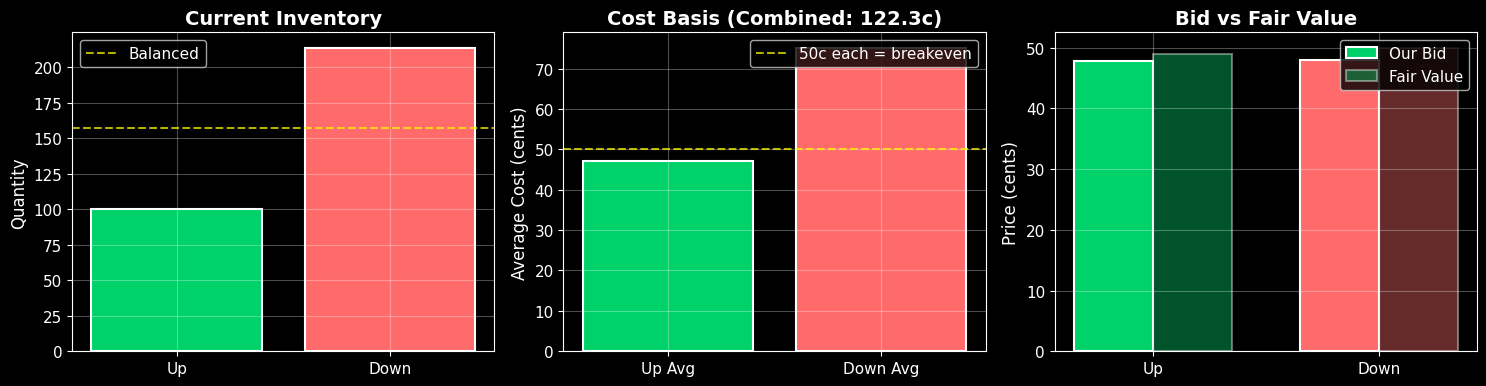


Spreads: Up = 1.23c, Down = 2.11c
Combined bid: 95.7c (vs current avg 122.3c)


In [6]:
# Visualize current position and quotes
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# 1. Position sizes
ax1 = axes[0]
bars = ax1.bar(['Up', 'Down'], [up_pos.qty, down_pos.qty], 
               color=['#00d26a', '#ff6b6b'], edgecolor='white', linewidth=1.5)
ax1.axhline(y=(up_pos.qty + down_pos.qty)/2, color='yellow', linestyle='--', alpha=0.7, label='Balanced')
ax1.set_ylabel('Quantity', fontsize=12)
ax1.set_title('Current Inventory', fontsize=14, fontweight='bold')
ax1.legend()

# 2. Cost breakdown
ax2 = axes[1]
costs = [up_pos.avg_cost * 100, down_pos.avg_cost * 100]
bars = ax2.bar(['Up Avg', 'Down Avg'], costs, 
               color=['#00d26a', '#ff6b6b'], edgecolor='white', linewidth=1.5)
ax2.axhline(y=50, color='yellow', linestyle='--', alpha=0.7, label='50c each = breakeven')
ax2.set_ylabel('Average Cost (cents)', fontsize=12)
ax2.set_title(f'Cost Basis (Combined: {result.combined_cost*100:.1f}c)', fontsize=14, fontweight='bold')
ax2.legend()

# 3. Quotes vs fair value
ax3 = axes[2]
x = np.arange(2)
width = 0.35
ax3.bar(x - width/2, [result.bid_up*100, result.bid_down*100], width, 
        label='Our Bid', color=['#00d26a', '#ff6b6b'], edgecolor='white', linewidth=1.5)
ax3.bar(x + width/2, [fair_up*100, fair_down*100], width, 
        label='Fair Value', color=['#00d26a', '#ff6b6b'], alpha=0.4, edgecolor='white', linewidth=1.5)
ax3.set_ylabel('Price (cents)', fontsize=12)
ax3.set_title('Bid vs Fair Value', fontsize=14, fontweight='bold')
ax3.set_xticks(x)
ax3.set_xticklabels(['Up', 'Down'])
ax3.legend()

plt.tight_layout()
plt.show()

print(f"\nSpreads: Up = {result.spread_up*100:.2f}c, Down = {result.spread_down*100:.2f}c")
print(f"Combined bid: {(result.bid_up + result.bid_down)*100:.1f}c (vs current avg {result.combined_cost*100:.1f}c)")

---
## 4. Spread Decomposition

Let's break down how the spread is computed step by step.

In [7]:
# Manual calculation to show each component
q = (up_pos.qty - down_pos.qty) / (up_pos.qty + down_pos.qty)
epsilon = max(0, up_pos.avg_cost + down_pos.avg_cost - 1)

print("SPREAD DECOMPOSITION")
print("=" * 50)
print(f"\n1. State Variables:")
print(f"   Imbalance q = {q:.4f}")
print(f"   Cost excess ε = {epsilon:.4f} ({epsilon*100:.1f}%)")

print(f"\n2. Base Spread (widens with cost):")
cost_mult = 1 + quoter.gamma_cost * epsilon
base = quoter.delta_base * cost_mult
print(f"   cost_multiplier = 1 + {quoter.gamma_cost} × {epsilon:.4f} = {cost_mult:.3f}")
print(f"   base_spread = {quoter.delta_base*100:.1f}c × {cost_mult:.3f} = {base*100:.2f}c")

print(f"\n3. Skew (depends on imbalance, amplified by cost):")
int_mult = 1 + quoter.gamma_int * epsilon
skew = quoter.gamma_inv * q * int_mult
print(f"   interaction_mult = 1 + {quoter.gamma_int} × {epsilon:.4f} = {int_mult:.3f}")
print(f"   skew = {quoter.gamma_inv} × {q:.4f} × {int_mult:.3f} = {skew:.4f}")

print(f"\n4. Final Spreads (multiplicative application):")
spread_up = base * (1 + skew)
spread_down = base * (1 - skew)
print(f"   spread_up = {base*100:.2f}c × (1 + {skew:.4f}) = {spread_up*100:.2f}c")
print(f"   spread_down = {base*100:.2f}c × (1 - {skew:.4f}) = {spread_down*100:.2f}c")

print(f"\n5. Bid Prices:")
print(f"   bid_up = {fair_up*100:.0f}c - {spread_up*100:.2f}c = {(fair_up - spread_up)*100:.1f}c")
print(f"   bid_down = {fair_down*100:.0f}c - {spread_down*100:.2f}c = {(fair_down - spread_down)*100:.1f}c")

SPREAD DECOMPOSITION

1. State Variables:
   Imbalance q = -0.3631
   Cost excess ε = 0.2230 (22.3%)

2. Base Spread (widens with cost):
   cost_multiplier = 1 + 3.0 × 0.2230 = 1.669
   base_spread = 1.0c × 1.669 = 1.67c

3. Skew (depends on imbalance, amplified by cost):
   interaction_mult = 1 + 2.0 × 0.2230 = 1.446
   skew = 0.5 × -0.3631 × 1.446 = -0.2625

4. Final Spreads (multiplicative application):
   spread_up = 1.67c × (1 + -0.2625) = 1.23c
   spread_down = 1.67c × (1 - -0.2625) = 2.11c

5. Bid Prices:
   bid_up = 49c - 1.23c = 47.8c
   bid_down = 50c - 2.11c = 47.9c


---
## 5. Sensitivity Analysis: Imbalance Effect

How spreads change with imbalance at different cost levels.

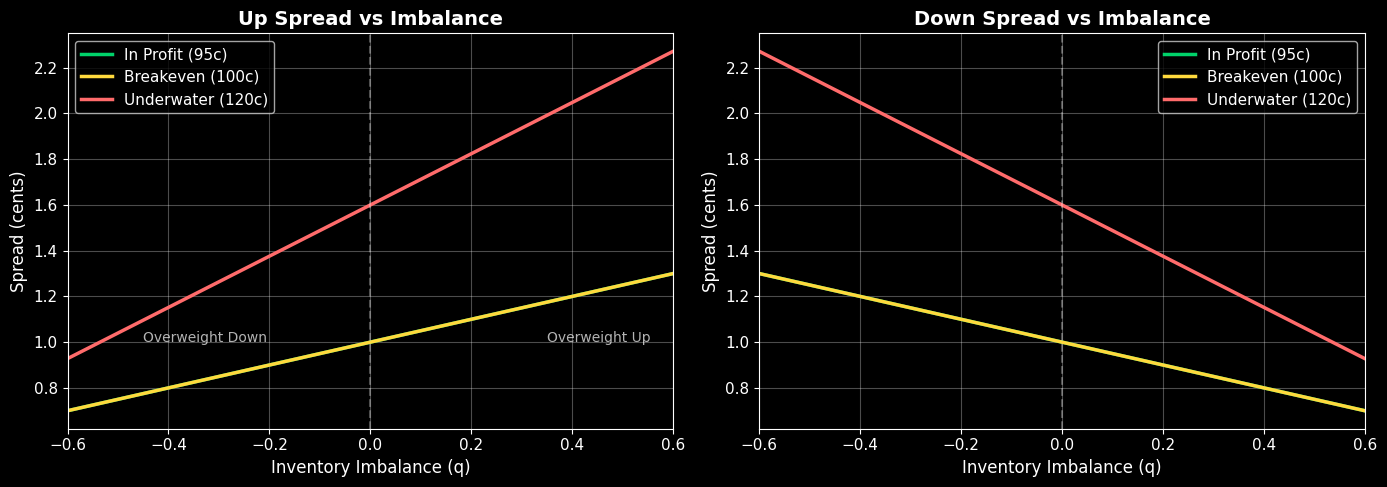

KEY INSIGHT: Notice how the skew is more pronounced (steeper slope) when underwater.
This is the interaction term at work: γ_int amplifies the imbalance effect.


In [8]:
imbalances = np.linspace(-0.6, 0.6, 50)

# Test at three cost levels
cost_levels = {
    'In Profit (95c)': 0.95,
    'Breakeven (100c)': 1.00,
    'Underwater (120c)': 1.20,
}

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
colors = ['#00d26a', '#ffd93d', '#ff6b6b']

for (name, cost), color in zip(cost_levels.items(), colors):
    spreads_up, spreads_down = [], []
    
    for q in imbalances:
        q_up = 200 * (1 + q)
        q_down = 200 * (1 - q)
        up_p = Position("Up", q_up, cost/2)
        down_p = Position("Down", q_down, cost/2)
        
        res = quoter.quote(up_p, down_p, fair_up, fair_down, 100)
        spreads_up.append(res.spread_up * 100)
        spreads_down.append(res.spread_down * 100)
    
    axes[0].plot(imbalances, spreads_up, label=name, color=color, linewidth=2.5)
    axes[1].plot(imbalances, spreads_down, label=name, color=color, linewidth=2.5)

for ax, title in zip(axes, ['Up Spread', 'Down Spread']):
    ax.set_xlabel('Inventory Imbalance (q)', fontsize=12)
    ax.set_ylabel('Spread (cents)', fontsize=12)
    ax.set_title(f'{title} vs Imbalance', fontsize=14, fontweight='bold')
    ax.legend()
    ax.axvline(x=0, color='white', linestyle='--', alpha=0.3)
    ax.set_xlim(-0.6, 0.6)

axes[0].annotate('Overweight Down', xy=(-0.45, 1), fontsize=10, alpha=0.7)
axes[0].annotate('Overweight Up', xy=(0.35, 1), fontsize=10, alpha=0.7)

plt.tight_layout()
plt.show()

print("KEY INSIGHT: Notice how the skew is more pronounced (steeper slope) when underwater.")
print("This is the interaction term at work: γ_int amplifies the imbalance effect.")

---
## 6. Sensitivity Analysis: Cost Effect

How spreads change with cost at different imbalance levels.

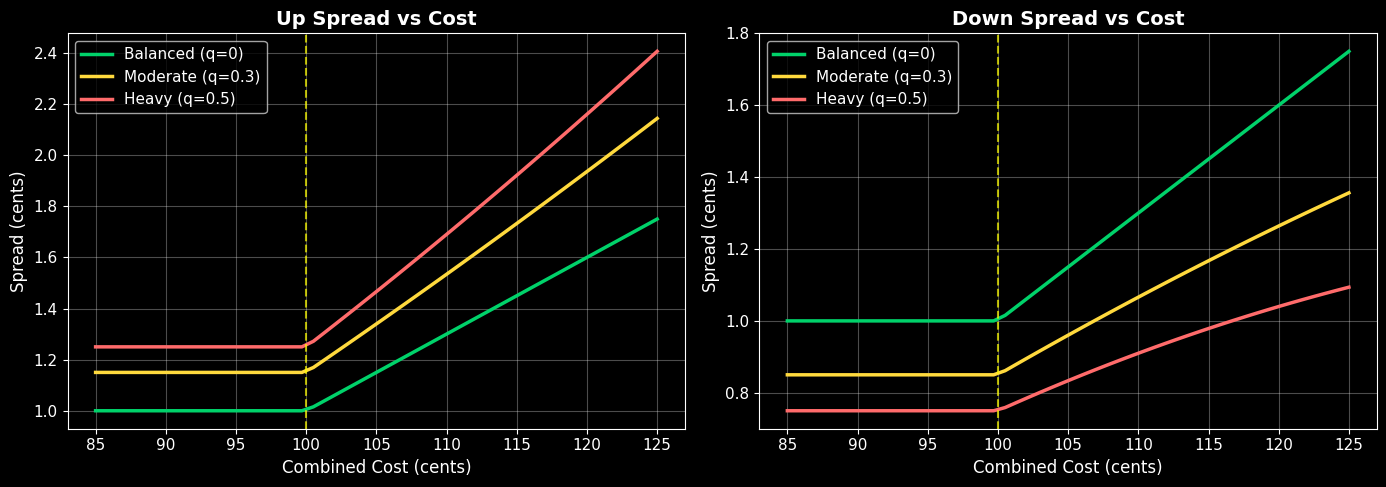

KEY INSIGHT: Up spread increases faster with cost when overweight Up.
Down spread actually decreases as cost increases when overweight Up (tighter to encourage fills).


In [9]:
costs = np.linspace(0.85, 1.25, 50)

# Test at three imbalance levels
imb_levels = {
    'Balanced (q=0)': 0.0,
    'Moderate (q=0.3)': 0.3,
    'Heavy (q=0.5)': 0.5,
}

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
colors = ['#00d26a', '#ffd93d', '#ff6b6b']

for (name, q), color in zip(imb_levels.items(), colors):
    spreads_up, spreads_down = [], []
    
    for cost in costs:
        q_up = 200 * (1 + q)
        q_down = 200 * (1 - q)
        up_p = Position("Up", q_up, cost/2)
        down_p = Position("Down", q_down, cost/2)
        
        res = quoter.quote(up_p, down_p, fair_up, fair_down, 100)
        spreads_up.append(res.spread_up * 100)
        spreads_down.append(res.spread_down * 100)
    
    axes[0].plot(costs * 100, spreads_up, label=name, color=color, linewidth=2.5)
    axes[1].plot(costs * 100, spreads_down, label=name, color=color, linewidth=2.5)

for ax, title in zip(axes, ['Up Spread', 'Down Spread']):
    ax.set_xlabel('Combined Cost (cents)', fontsize=12)
    ax.set_ylabel('Spread (cents)', fontsize=12)
    ax.set_title(f'{title} vs Cost', fontsize=14, fontweight='bold')
    ax.legend()
    ax.axvline(x=100, color='yellow', linestyle='--', alpha=0.7, label='Breakeven')

plt.tight_layout()
plt.show()

print("KEY INSIGHT: Up spread increases faster with cost when overweight Up.")
print("Down spread actually decreases as cost increases when overweight Up (tighter to encourage fills).")

---
## 7. 2D Heatmaps: Full Interaction Surface

In [10]:
# Create 2D grid
imb_range = np.linspace(-0.5, 0.5, 40)
cost_range = np.linspace(0.90, 1.20, 40)

spread_up_grid = np.zeros((len(cost_range), len(imb_range)))
spread_down_grid = np.zeros((len(cost_range), len(imb_range)))
combined_bid_grid = np.zeros((len(cost_range), len(imb_range)))

for i, tc in enumerate(cost_range):
    for j, q in enumerate(imb_range):
        q_up = 200 * (1 + q)
        q_down = 200 * (1 - q)
        up_p = Position("Up", q_up, tc/2)
        down_p = Position("Down", q_down, tc/2)
        
        res = quoter.quote(up_p, down_p, fair_up, fair_down, 100)
        
        spread_up_grid[i, j] = res.spread_up * 100
        spread_down_grid[i, j] = res.spread_down * 100
        combined_bid_grid[i, j] = (res.bid_up + res.bid_down) * 100

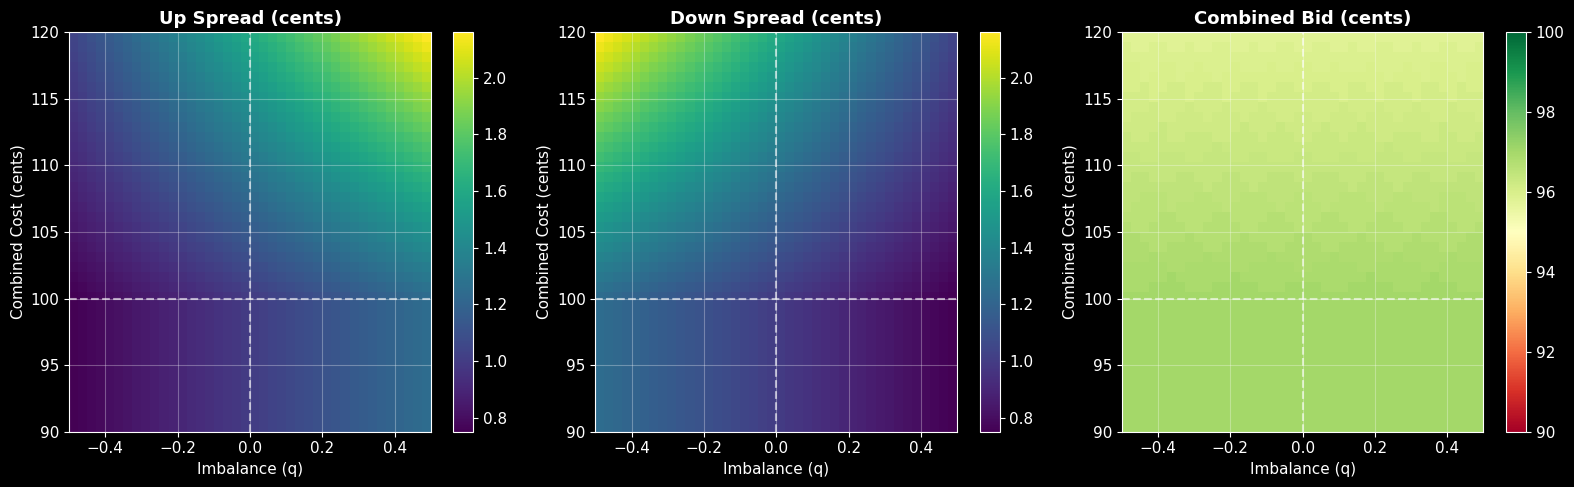

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

extent = [imb_range[0], imb_range[-1], cost_range[0]*100, cost_range[-1]*100]

# Up spread
im1 = axes[0].imshow(spread_up_grid, extent=extent, aspect='auto', origin='lower', cmap='viridis')
axes[0].set_title('Up Spread (cents)', fontsize=13, fontweight='bold')
axes[0].set_xlabel('Imbalance (q)')
axes[0].set_ylabel('Combined Cost (cents)')
axes[0].axhline(y=100, color='white', linestyle='--', alpha=0.6)
axes[0].axvline(x=0, color='white', linestyle='--', alpha=0.6)
plt.colorbar(im1, ax=axes[0])

# Down spread
im2 = axes[1].imshow(spread_down_grid, extent=extent, aspect='auto', origin='lower', cmap='viridis')
axes[1].set_title('Down Spread (cents)', fontsize=13, fontweight='bold')
axes[1].set_xlabel('Imbalance (q)')
axes[1].set_ylabel('Combined Cost (cents)')
axes[1].axhline(y=100, color='white', linestyle='--', alpha=0.6)
axes[1].axvline(x=0, color='white', linestyle='--', alpha=0.6)
plt.colorbar(im2, ax=axes[1])

# Combined bid
im3 = axes[2].imshow(combined_bid_grid, extent=extent, aspect='auto', origin='lower', cmap='RdYlGn', vmin=90, vmax=100)
axes[2].set_title('Combined Bid (cents)', fontsize=13, fontweight='bold')
axes[2].set_xlabel('Imbalance (q)')
axes[2].set_ylabel('Combined Cost (cents)')
axes[2].axhline(y=100, color='white', linestyle='--', alpha=0.6)
axes[2].axvline(x=0, color='white', linestyle='--', alpha=0.6)
plt.colorbar(im3, ax=axes[2])

plt.tight_layout()
plt.show()

---
## 8. Parameter Tuning Guide

In [ ]:
# Different configurations (all using VALID tick-sized spreads)
# Note: delta_base must be >= TICK_SIZE (0.01)
configs = {
    'Tight (Volume)': ContinuousQuoter(
        delta_base=0.01,  # 1 tick - minimum possible
        gamma_cost=2.0, gamma_inv=0.3, gamma_int=1.0
    ),
    'Balanced': ContinuousQuoter(
        delta_base=0.02,  # 2 ticks
        gamma_cost=3.0, gamma_inv=0.5, gamma_int=2.0
    ),
    'Wide (Conservative)': ContinuousQuoter(
        delta_base=0.03,  # 3 ticks
        gamma_cost=4.0, gamma_inv=0.7, gamma_int=3.0
    ),
}

print("PARAMETER COMPARISON (all spreads in whole ticks)")
print("=" * 75)
print(f"Your position: Up {up_pos.qty}@{up_pos.avg_cost:.2f} | Down {down_pos.qty}@{down_pos.avg_cost:.2f}")
print(f"Fair: Up={fair_up:.2f}, Down={fair_down:.2f}")
print("=" * 75)

for name, q in configs.items():
    res = q.quote(up_pos, down_pos, fair_up, fair_down, 100)
    print(f"\n{name}:")
    print(f"  Bids:    Up={res.bid_up:.2f}  Down={res.bid_down:.2f}")
    print(f"  Spreads: Up={res.spread_up:.2f} ({int(res.spread_up*100)}c)  Down={res.spread_down:.2f} ({int(res.spread_down*100)}c)")
    print(f"  Combined bid: {(res.bid_up + res.bid_down):.2f}")

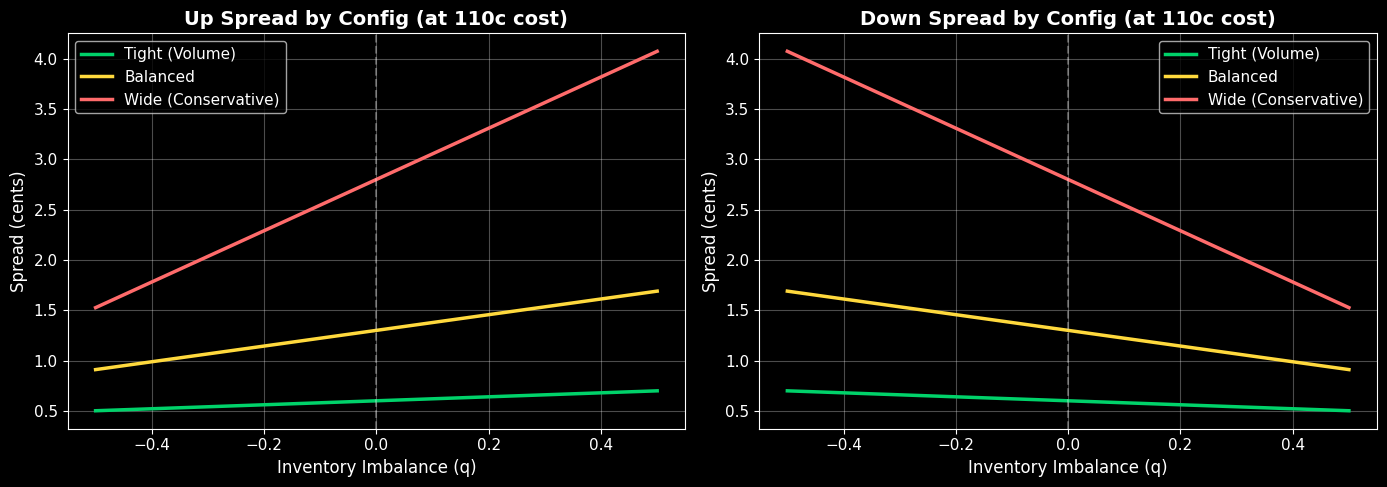

In [13]:
# Visualize across imbalance
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
imbalances = np.linspace(-0.5, 0.5, 50)
colors = {'Tight (Volume)': '#00d26a', 'Balanced': '#ffd93d', 'Wide (Conservative)': '#ff6b6b'}

for name, quoter_cfg in configs.items():
    spr_up, spr_down = [], []
    for q in imbalances:
        q_up = 200 * (1 + q)
        q_down = 200 * (1 - q)
        up_p = Position("Up", q_up, 0.55)  # 110c cost (slightly underwater)
        down_p = Position("Down", q_down, 0.55)
        
        res = quoter_cfg.quote(up_p, down_p, fair_up, fair_down, 100)
        spr_up.append(res.spread_up * 100)
        spr_down.append(res.spread_down * 100)
    
    axes[0].plot(imbalances, spr_up, label=name, color=colors[name], linewidth=2.5)
    axes[1].plot(imbalances, spr_down, label=name, color=colors[name], linewidth=2.5)

for ax, title in zip(axes, ['Up Spread', 'Down Spread']):
    ax.set_xlabel('Inventory Imbalance (q)', fontsize=12)
    ax.set_ylabel('Spread (cents)', fontsize=12)
    ax.set_title(f'{title} by Config (at 110c cost)', fontsize=14, fontweight='bold')
    ax.legend()
    ax.axvline(x=0, color='white', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

---
## 9. Sizes (Function of Imbalance Only)

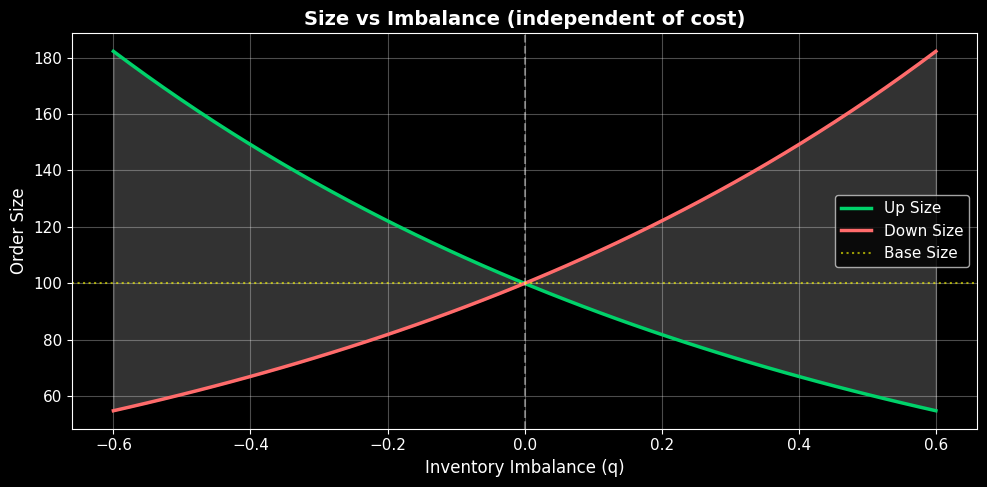

Sizes are purely a function of imbalance, not cost.
When overweight Up (q > 0): reduce Up size, increase Down size.


In [14]:
imbalances = np.linspace(-0.6, 0.6, 50)
sizes_up = [100 * math.exp(-quoter.lambda_size * q) for q in imbalances]
sizes_down = [100 * math.exp(quoter.lambda_size * q) for q in imbalances]

fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(imbalances, sizes_up, label='Up Size', color='#00d26a', linewidth=2.5)
ax.plot(imbalances, sizes_down, label='Down Size', color='#ff6b6b', linewidth=2.5)
ax.axvline(x=0, color='white', linestyle='--', alpha=0.4)
ax.axhline(y=100, color='yellow', linestyle=':', alpha=0.6, label='Base Size')
ax.fill_between(imbalances, sizes_up, sizes_down, alpha=0.2, color='white')

ax.set_xlabel('Inventory Imbalance (q)', fontsize=12)
ax.set_ylabel('Order Size', fontsize=12)
ax.set_title('Size vs Imbalance (independent of cost)', fontsize=14, fontweight='bold')
ax.legend()

plt.tight_layout()
plt.show()

print("Sizes are purely a function of imbalance, not cost.")
print("When overweight Up (q > 0): reduce Up size, increase Down size.")

---
## 10. Simulation: Cost Recovery Over Time

In [15]:
def simulate_fills(up_pos, down_pos, quoter, fair_up, fair_down, n_rounds=50, fill_prob=0.6):
    """Simulate fills and track position evolution"""
    np.random.seed(42)
    
    history = [{
        'round': 0,
        'up_qty': up_pos.qty, 'down_qty': down_pos.qty,
        'up_avg': up_pos.avg_cost, 'down_avg': down_pos.avg_cost,
        'combined_cost': up_pos.avg_cost + down_pos.avg_cost,
        'imbalance': (up_pos.qty - down_pos.qty) / (up_pos.qty + down_pos.qty),
    }]
    
    curr_up = Position("Up", up_pos.qty, up_pos.avg_cost)
    curr_down = Position("Down", down_pos.qty, down_pos.avg_cost)
    
    for i in range(1, n_rounds + 1):
        quote = quoter.quote(curr_up, curr_down, fair_up, fair_down, 50)
        
        # Fill probability weighted by size
        up_fill_weight = quote.size_up / (quote.size_up + quote.size_down)
        
        if np.random.random() > fill_prob:
            pass  # No fill
        elif np.random.random() < up_fill_weight:
            # Up fills
            fill = min(quote.size_up, 30)
            new_qty = curr_up.qty + fill
            new_avg = (curr_up.qty * curr_up.avg_cost + fill * quote.bid_up) / new_qty
            curr_up = Position("Up", new_qty, new_avg)
        else:
            # Down fills
            fill = min(quote.size_down, 30)
            new_qty = curr_down.qty + fill
            new_avg = (curr_down.qty * curr_down.avg_cost + fill * quote.bid_down) / new_qty
            curr_down = Position("Down", new_qty, new_avg)
        
        history.append({
            'round': i,
            'up_qty': curr_up.qty, 'down_qty': curr_down.qty,
            'up_avg': curr_up.avg_cost, 'down_avg': curr_down.avg_cost,
            'combined_cost': curr_up.avg_cost + curr_down.avg_cost,
            'imbalance': (curr_up.qty - curr_down.qty) / (curr_up.qty + curr_down.qty),
        })
    
    return pd.DataFrame(history)

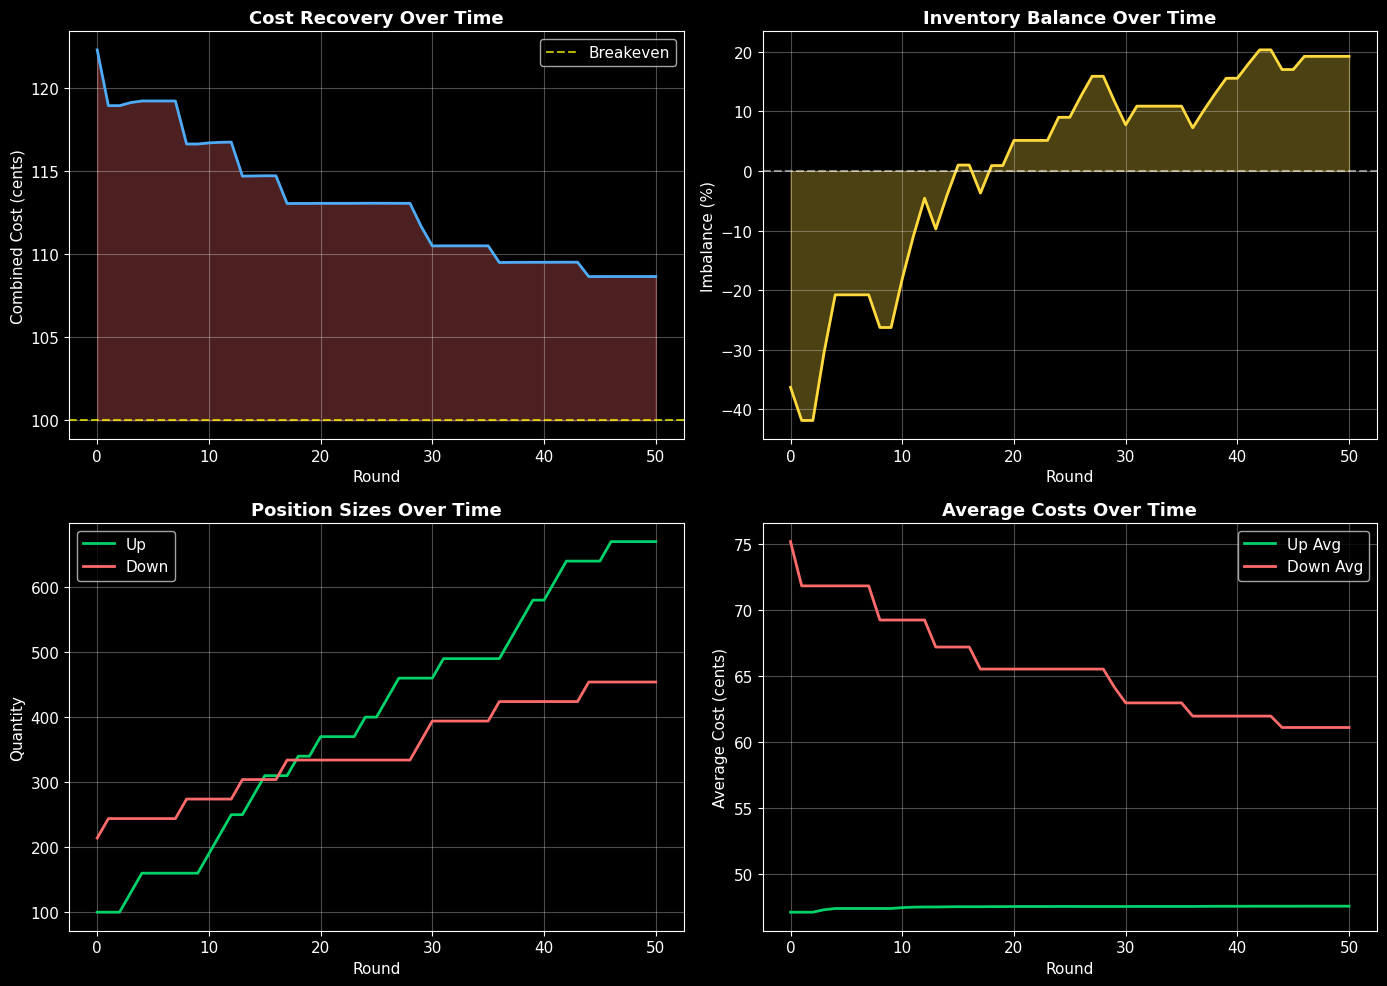


Simulation Summary:
  Start cost: 122.3c
  End cost:   108.7c
  Improvement: 13.6c


In [16]:
sim_df = simulate_fills(up_pos, down_pos, quoter, fair_up, fair_down, n_rounds=50)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Combined cost
ax1 = axes[0, 0]
ax1.plot(sim_df['round'], sim_df['combined_cost'] * 100, color='#4dabf7', linewidth=2)
ax1.axhline(y=100, color='yellow', linestyle='--', alpha=0.7, label='Breakeven')
ax1.fill_between(sim_df['round'], sim_df['combined_cost']*100, 100,
                  where=sim_df['combined_cost']<1, alpha=0.3, color='#00d26a')
ax1.fill_between(sim_df['round'], sim_df['combined_cost']*100, 100,
                  where=sim_df['combined_cost']>=1, alpha=0.3, color='#ff6b6b')
ax1.set_xlabel('Round')
ax1.set_ylabel('Combined Cost (cents)')
ax1.set_title('Cost Recovery Over Time', fontsize=13, fontweight='bold')
ax1.legend()

# Imbalance
ax2 = axes[0, 1]
ax2.plot(sim_df['round'], sim_df['imbalance']*100, color='#ffd93d', linewidth=2)
ax2.axhline(y=0, color='white', linestyle='--', alpha=0.5)
ax2.fill_between(sim_df['round'], sim_df['imbalance']*100, 0, alpha=0.3, color='#ffd93d')
ax2.set_xlabel('Round')
ax2.set_ylabel('Imbalance (%)')
ax2.set_title('Inventory Balance Over Time', fontsize=13, fontweight='bold')

# Quantities
ax3 = axes[1, 0]
ax3.plot(sim_df['round'], sim_df['up_qty'], label='Up', color='#00d26a', linewidth=2)
ax3.plot(sim_df['round'], sim_df['down_qty'], label='Down', color='#ff6b6b', linewidth=2)
ax3.set_xlabel('Round')
ax3.set_ylabel('Quantity')
ax3.set_title('Position Sizes Over Time', fontsize=13, fontweight='bold')
ax3.legend()

# Average costs
ax4 = axes[1, 1]
ax4.plot(sim_df['round'], sim_df['up_avg']*100, label='Up Avg', color='#00d26a', linewidth=2)
ax4.plot(sim_df['round'], sim_df['down_avg']*100, label='Down Avg', color='#ff6b6b', linewidth=2)
ax4.set_xlabel('Round')
ax4.set_ylabel('Average Cost (cents)')
ax4.set_title('Average Costs Over Time', fontsize=13, fontweight='bold')
ax4.legend()

plt.tight_layout()
plt.show()

print(f"\nSimulation Summary:")
print(f"  Start cost: {sim_df['combined_cost'].iloc[0]*100:.1f}c")
print(f"  End cost:   {sim_df['combined_cost'].iloc[-1]*100:.1f}c")
print(f"  Improvement: {(sim_df['combined_cost'].iloc[0] - sim_df['combined_cost'].iloc[-1])*100:.1f}c")

---
## 11. Production Usage

In [17]:
def get_quotes(
    up_qty: float, up_avg: float,
    down_qty: float, down_avg: float,
    fair_up: float, fair_down: float,
    base_size: float = 100,
    # Parameters
    delta_base: float = 0.01,
    gamma_cost: float = 3.0,
    gamma_inv: float = 0.5,
    gamma_int: float = 2.0,
    lambda_size: float = 1.0,
) -> dict:
    """Production wrapper for the quoter"""
    quoter = ContinuousQuoter(
        delta_base=delta_base,
        gamma_cost=gamma_cost,
        gamma_inv=gamma_inv,
        gamma_int=gamma_int,
        lambda_size=lambda_size,
    )
    
    result = quoter.quote(
        Position("Up", up_qty, up_avg),
        Position("Down", down_qty, down_avg),
        fair_up, fair_down, base_size
    )
    
    return {
        "up": {"bid": round(result.bid_up, 2), "size": int(result.size_up)},
        "down": {"bid": round(result.bid_down, 2), "size": int(result.size_down)},
        "combined_bid": round(result.bid_up + result.bid_down, 3),
        "state": {
            "imbalance": round(result.q_imbalance, 3),
            "cost_excess": round(result.cost_excess, 3),
        }
    }

# Example
quotes = get_quotes(
    up_qty=208, up_avg=0.471,
    down_qty=214, down_avg=0.752,
    fair_up=0.29, fair_down=0.72
)
print("Production output:")
print(quotes)

Production output:
{'up': {'bid': 0.27, 'size': 101}, 'down': {'bid': 0.7, 'size': 98}, 'combined_bid': 0.976, 'state': {'imbalance': -0.014, 'cost_excess': 0.223}}


---
## 12. Summary

### Key Equations

**Base spread** (widens with cost):
$$\delta_{base}^* = \delta_{base} \cdot (1 + \gamma_{cost} \cdot \varepsilon)$$

**Skew** (imbalance effect, amplified when underwater):
$$\text{skew} = \gamma_{inv} \cdot q \cdot (1 + \gamma_{int} \cdot \varepsilon)$$

**Final spreads**:
$$\delta_{up} = \delta_{base}^* \cdot (1 + \text{skew})$$
$$\delta_{down} = \delta_{base}^* \cdot (1 - \text{skew})$$

### Parameters

| Parameter | Description | Typical Range |
|-----------|-------------|---------------|
| `delta_base` | Minimum spread (profit + balanced) | 0.005 - 0.02 |
| `gamma_cost` | Cost sensitivity | 2.0 - 5.0 |
| `gamma_inv` | Imbalance sensitivity | 0.3 - 0.7 |
| `gamma_int` | Interaction (amplifies skew underwater) | 1.0 - 3.0 |
| `lambda_size` | Size decay rate | 0.5 - 2.0 |